# EXTRACTER: Efficient Texture Matching with Attention and Gradient Enhancing for Large Scale Image Super Resolution

### Esteban Reyes-Saldaña, Mariano Rivera

### esteban.reyes@cimat.mx

#### Ago 30 2023

In [1]:
from utils.files import mkExpDir
from dataset import dataloader
from model import EXTRACTER
from loss.loss import get_loss_dict
from trainer import Trainer

import os
import torch
import torch.nn as nn
import warnings
import glob
import time

from argparse import Namespace
from torchinfo import summary
from utils.ploting import plot_results

warnings.filterwarnings('ignore')

/opt/miniconda3/envs/torch_latest/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/miniconda3/envs/torch_latest/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


# Args

In [2]:
args   = Namespace()

## log setting

In [3]:
args.save_dir      = 'extracter_rec'
args.reset         =  True
args.log_file_name = 'EXTRACTER.log'
args.logger_name   = 'EXTRACTER'

## dataset setting

In [4]:
args.dataset       = 'CUFED'                      # Which dataset to train and test
args.dataset_dir   = r'/home/esteban/Data/CUFED/' # Directory of dataset
args.num_workers   = 9

## model setting

In [5]:
args.img_training_size = 160
args.num_res_blocks    = '8+16+8+4'  # Residual blocks for features [IFE, lv1, lv2, lv3]
args.num_grad_blocks   = '8+9+9+9'   # # Residual blocks for features [IFE, lv1, lv2, lv3]
args.n_feats           = 64          # The number of channels in network
args.top_k             = 2           # Top K matches for each patch

args.GAN_type          = 'WGAN_GP'   # The type of GAN used in training
args.GAN_k             = 2           # Training discriminator k times when training generator once

args.rec_w             = 1.0         # The weight of reconstruction loss
args.per_w             = 1e-2        # The weight of perceptual loss
args.grd_w             = 1e-3        # The weight of transferal perceptual loss
args.adv_w             = 1e-3        # The weight of adversarial loss

In [6]:
## Patch Setting and Top Features Setting
args.unfold_kernel_size = 3
args.stride             = 1
args.padding            = 1

## optimizer setting

In [7]:
args.beta1          = 0.9    # The beta1 in Adam optimizer
args.beta2          = 0.999  # The beta2 in Adam optimizer
args.eps            = 1e-8   # The eps in Adam optimizer

args.lr_rate        = 1e-4   # Learning rate
args.lr_rate_dis    = 1e-4   # Learning rate of discriminator
args.lr_rate_lte    = 1e-5  # Learning rate of LTE
args.decay          = 1e-4   # Learning rate decay type
args.gamma          = 0.5    # Learning rate decay factor for step decay

## training setting

In [8]:
args.batch_size      = 9    # Training batch size
args.num_init_epochs = 600  # The number of init epochs which are trained with only reconstruction loss
args.num_epochs      = 0    # The number of training epochs
args.print_every     = 600  # Print period
args.save_every      = 5    # Save period
args.val_every       = 1    # Validation period
args.show_every      = 5    # Plot Results


## evaluate / test / finetune setting
args.eval              = True                      # Evaluation mode
args.eval_save_results = False                     # Save each image during evaluation
args.model_path        = None                      # The path of model to evaluation
args.test              = False                     # Test mode

# Main

In [9]:
_logger     = mkExpDir(args)
_dataloader = dataloader.get_dataloader(args) if (not args.test) else None

In [10]:
len(_dataloader['train'].dataset.input_list), len(_dataloader['test']['1'])

(11871, 126)

## device

In [11]:
args.cpu = False
device   = torch.device('cpu' if args.cpu else 'cuda') # Choose CPU or GPU
torch.cuda.set_device(0)                           

## model

In [12]:
_model    = EXTRACTER.EXTRACTER(args).to(device)
_loss_all = get_loss_dict(args, _logger)
t         = Trainer(args, _logger, _dataloader, _model, _loss_all)

In [13]:
summary(_model)

Layer (type:depth-idx)                   Param #
EXTRACTER                                --
├─FE: 1-1                                --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    └─MeanShift: 2-4                    (12)
├─SearchTransfer: 1-2                    --
├─gradient: 1-3                          (18)
├─CSFI: 1-4                              --
│ 

In [14]:
t.load('./EXTRACTER_REC.pt')

[trainer.py file line:40] - INFO: load_model_path: ./EXTRACTER_REC.pt


## Load pre trained model

In [15]:
t.evaluate(current_epoch = 0)

[trainer.py file line:109] - INFO: Epoch 0 evaluation process...
[trainer.py file line:133] - INFO: Ref  PSNR (now): 27.222 	 SSIM (now): 0.8103
[trainer.py file line:140] - INFO: Ref  PSNR (max): 27.222 (0) 	 SSIM (max): 0.8103 (0)
[trainer.py file line:180] - INFO: Evaluation over.


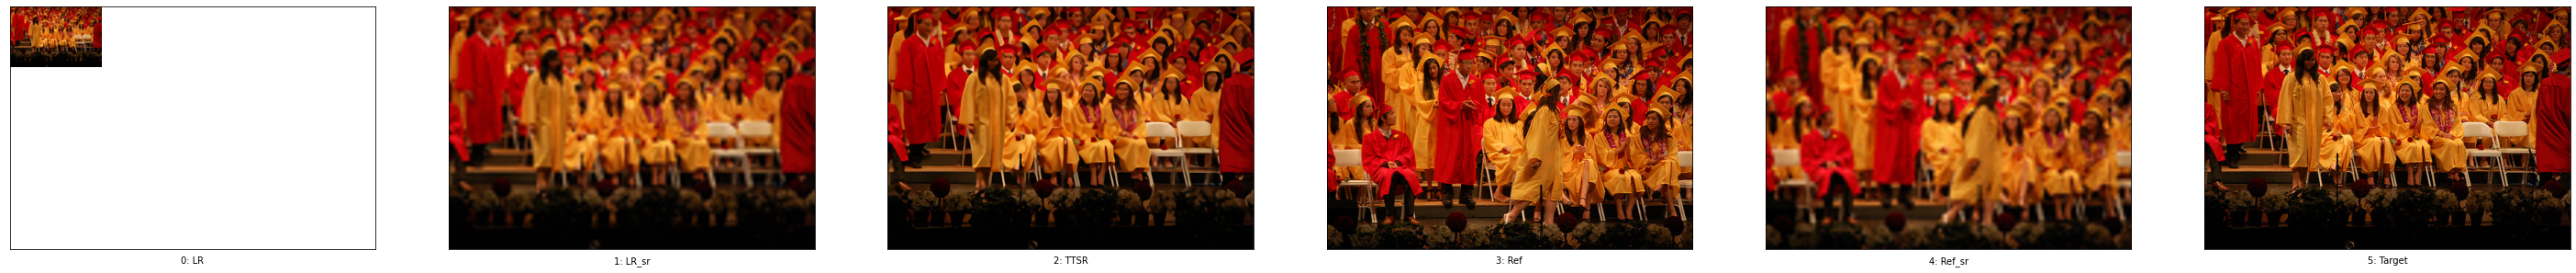

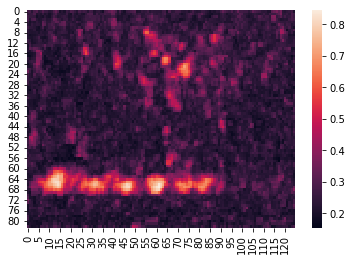

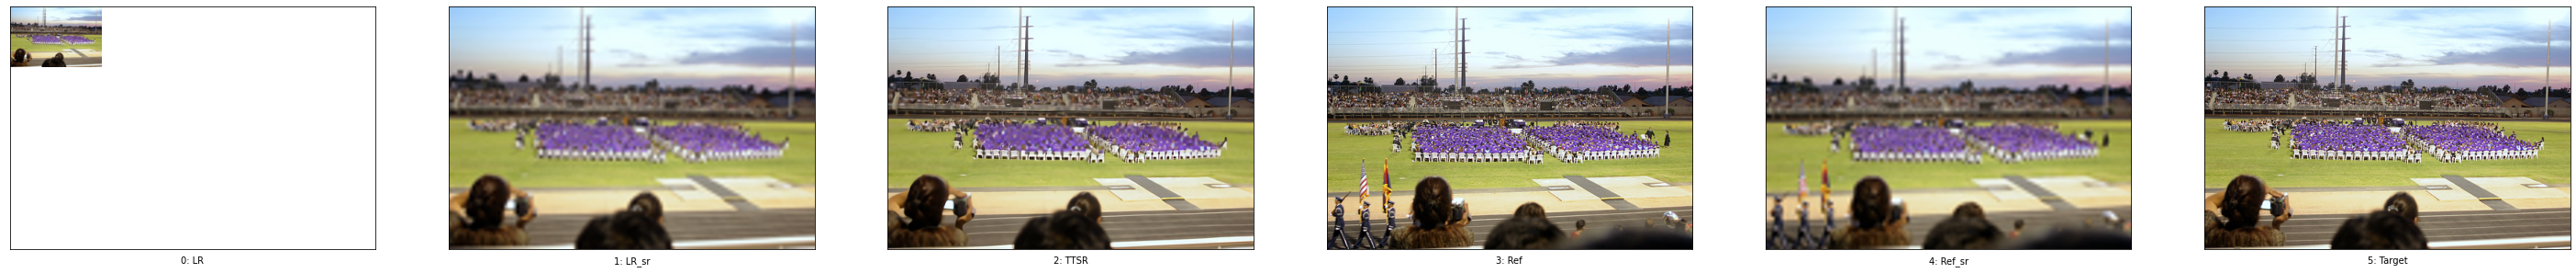

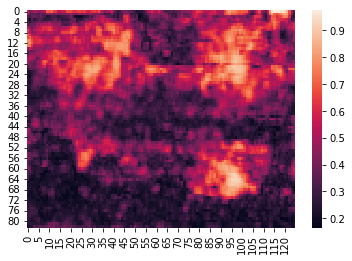

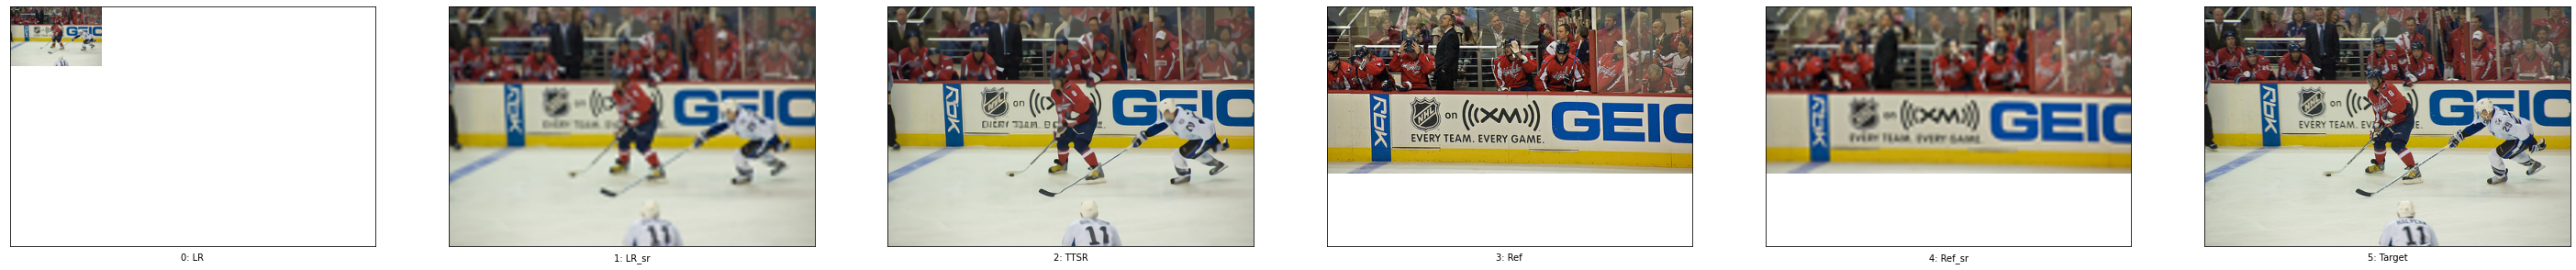

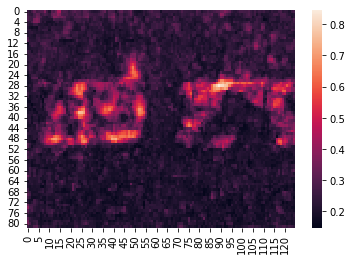

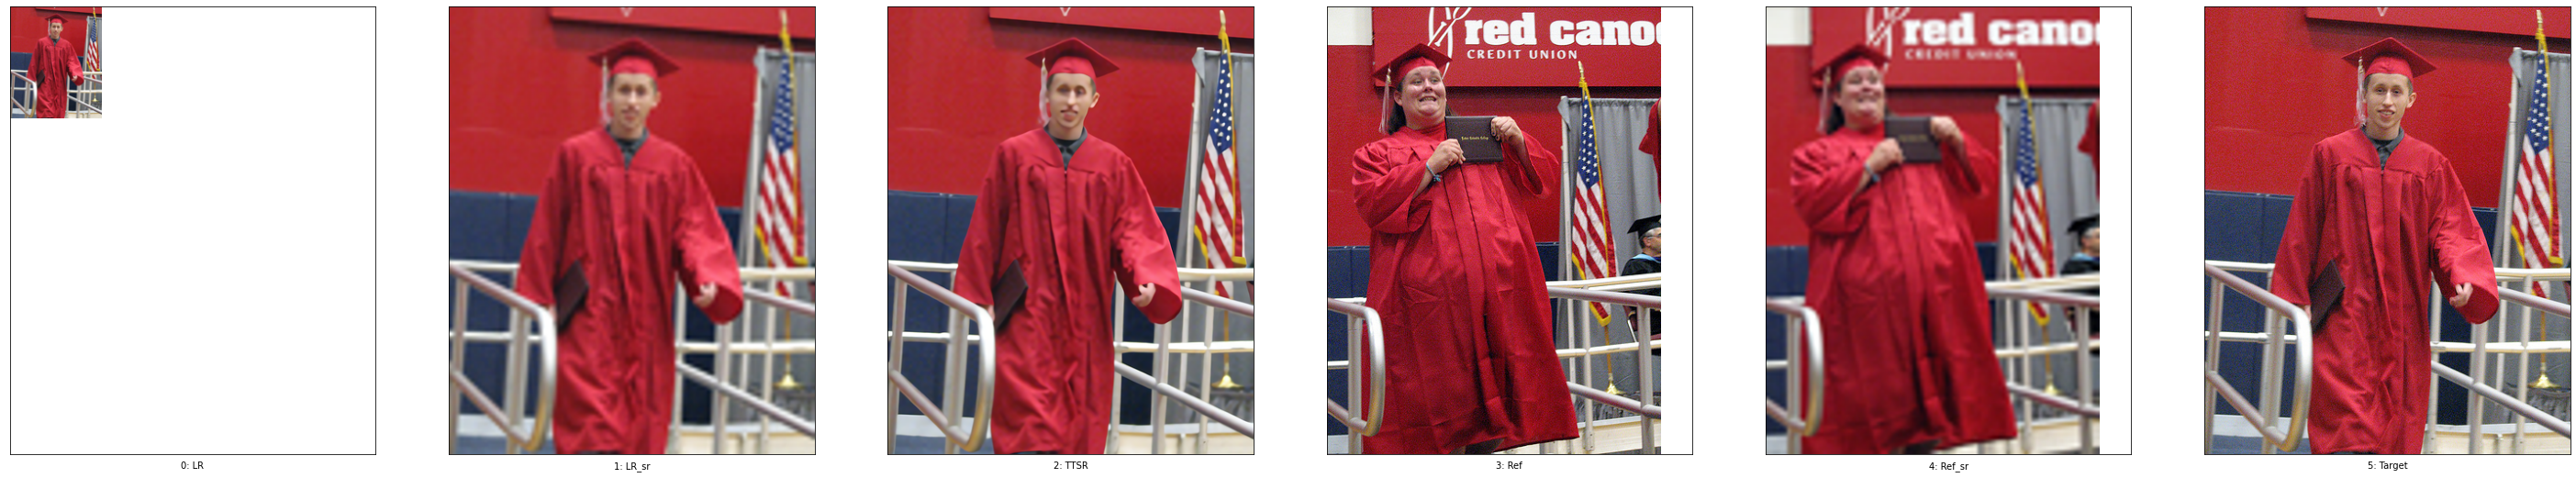

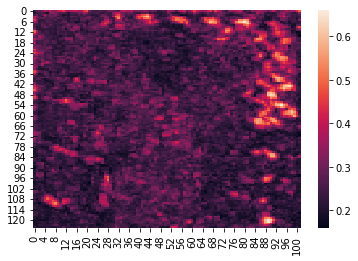

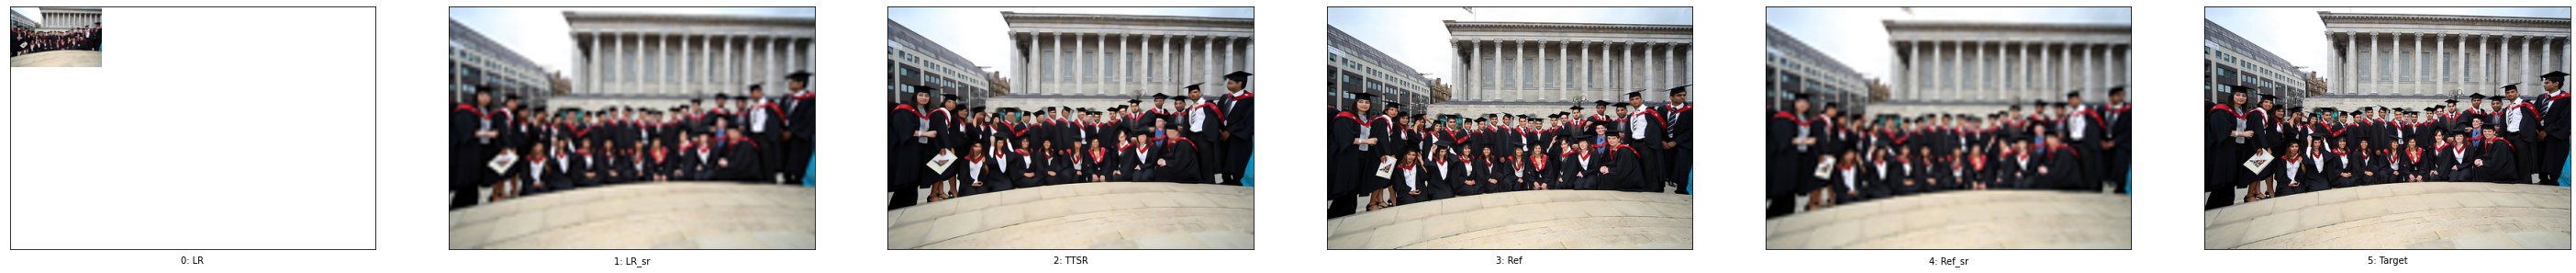

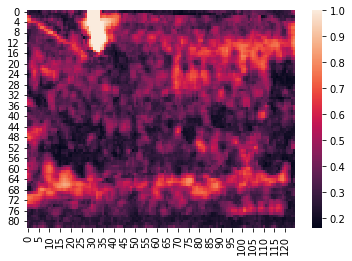

In [16]:
plot_results(model = t.model, dataloader = _dataloader, total_images = 5, save = True, epoch = 0, device = device, args = args)

## Training